In [1]:
import warnings
warnings.filterwarnings("ignore")
import glob
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from IPython.display import clear_output

In [2]:
import plotly
from plotly.offline import iplot
import plotly.graph_objs as go

In [3]:
plotly.offline.init_notebook_mode(connected=True)

In [4]:
import sys
sys.path.append("../pyfiles/")
from util import * 
from dataset import * 
from model import * 

# Get celebA dataset

# dataset

In [5]:
label_discription = [
    "male, smiling",
    "male, not smiling",
    "female, smiling",
    "female, not smiling"
]

In [6]:
root = "./../../dataset/celebA/img/"
label_root = "./../../dataset/celebA/label_folder/"

In [7]:
# 1 5 o clock shadow
# 11 blurry
# 14 chubby
# 15 double chin
# 16 eyeglasses
# 17 goatee
# 21 male
# 23 mustache
# 25 No_Beard
# 31 sideburns
# 32 smiling
# 36 wearing hat
# 40 young
dataset_label = {}
dataset_label["existed"] = [25] 
dataset_label["delete"] = [1, 11, 14, 15, 16, 17, 23, 31, 36] 
dataset_label["class"] = [21, 32] 

In [8]:
classes = tuple(range(2**len(dataset_label["class"])))
cl = get_class_label(len(dataset_label["class"]))
classes

(0, 1, 2, 3)

In [9]:
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])

class MinMax(object):
    def __init__(self, mean0=True):
        self.mean0 = mean0
        pass
    def __call__(self, img):
        return torch.Tensor(min_max(cuda2numpy(img), mean0=self.mean0))
    def __repr__(self):
        return self.__class__.__name__

transform = {}
transform["train"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    MinMax(True)
])
    
transform["test"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    MinMax(True)
])

In [10]:
each_train_num = 10000000
each_val_num = 0
each_test_num = 100
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
len(dataset), len(testset)

(134530, 400)

0


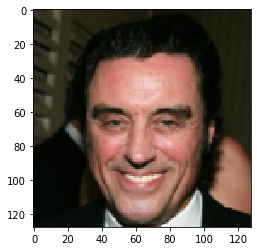

In [11]:
data = dataloader.dataset[24]
img = data[0]
image = image_from_output(torch.reshape(img, (1,img.shape[0],img.shape[1],img.shape[2])))[0]
print(data[1])
plt.imshow(image)

## Algorithm

In [12]:
class SingleGAN_training():
    def __init__(self, net, criterion, lbd, unrolled_k, device, ref_label):
        self.G, self.D, self.E = net[0], net[1], net[2]
        self.optG, self.optD, self.optE = None, None, None
        self.scheG, self.scheD, self.scheE = None, None, None
        self.criterion = criterion
        self.lbd = lbd
        self.k = unrolled_k
        self.device = device
        self.ref_label = ref_label
        self.source_image = None
        self.target_image = None
        self.label = None
        self.c_rand = None
        self.enc_info = None
        self.target_cenc = None
    
    def opt_sche_initialization(self, lr=[0.0001, 0.0001, 0.0001]):
        lr_G, lr_D, lr_E = lr
        self.optG = optim.Adam(self.G.parameters(), lr=lr_G, betas=(0.5, 0.999))
        self.scheG = optim.lr_scheduler.ExponentialLR(self.optG, gamma=0.95)
        self.optD = []
        self.scheD = []
        for i in classes:
            self.optD.append(optim.Adam(self.D[i].parameters(), lr=lr_D, betas=(0.5, 0.999)))
            self.scheD.append(optim.lr_scheduler.ExponentialLR(self.optD[i], gamma=0.95))
        self.optE = optim.Adam(self.E.parameters(), lr=lr_E, betas=(0.5, 0.999))
        self.scheE = optim.lr_scheduler.ExponentialLR(self.optE, gamma=0.95)
        return
        
    def G_transformation(self, target_label, source_image, encoder=False, ref_image=None):
        if encoder:
            class_vector = class_encode(target_label, self.device, self.ref_label)
            latent, mu, logvar = self.E(ref_image, class_vector)
            info = [latent, mu, logvar]
            latent_vector = latent
        else:
            latent_vector = torch.randn(source_image.shape[0], ndim).to(device)
            info = latent_vector
            
        class_vector = class_encode(target_label, self.device, self.ref_label)
        class_vector = torch.cat([class_vector, latent_vector], 1)
        target_image = self.G(source_image, class_vector)
        
        return target_image, info
        
    def update_D(self):
        self.target_image, self.c_rand = self.G_transformation(self.label["target"], self.source_image, False)
        
        all_errD = 0
        for i in classes:
            self.D[i].zero_grad()
            errD = 0
            real_image = self.source_image[self.label["source"]==i]
            if real_image.shape[0]!=0:
                output = self.D[i](real_image)
                errD_real = get_loss_D(output, 1., criterion, device)
            else:
                errD_real = 0
            errD += errD_real
            
            fake_image = self.target_image[self.label["target"]==i].detach()
            if fake_image.shape[0]!=0:
                output = self.D[i](fake_image)
                errD_fake = get_loss_D(output, 0., criterion, device)
            else:
                errD_fake = 0
            errD += errD_fake
            errD.backward()
            self.optD[i].step()
            all_errD += errD/len(classes)
            
        return all_errD
    
    def update_GandE(self):
        self.G.zero_grad()
        self.E.zero_grad()

        errG = 0
        errE = 0
        errE_output = 0

        ## ordinary SingleGAN loss
        recon_image, source_enc_info = self.G_transformation(self.label["source"], self.target_image, True, self.source_image)
        for i in classes:
            fake_image = self.target_image[self.label["target"]==i]
            if fake_image.shape[0]!=0:
                output = self.D[i](fake_image)
                errG_dis = get_loss_D(output, 1., criterion, device)
            else:
                errG_dis = 0
            errG += errG_dis/len(classes)
        errG_cycle = torch.mean(torch.abs(self.source_image - recon_image))
        errG += errG_cycle*self.lbd["cycle"]
        errE_output += errG_cycle * self.lbd["cycle"]
        
        ## multimodal transformation (KL)
        _, mu, logvar = source_enc_info
        errE_KL = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp_()) 
        errE += errE_KL*self.lbd["KL"]
        errE_output += errE_KL*self.lbd["KL"]
        
        ## Identity loss under source style condition
        if self.lbd["idt"] > 0:
            identity_image, _ = self.G_transformation(self.label["source"], self.source_image, True, self.source_image)
            errG_idt = torch.mean(torch.abs(self.source_image - identity_image))
            errG += errG_idt*self.lbd["idt"]
            errE_output += errG_idt*self.lbd["idt"]
            
        errG.backward(retain_graph=True)
        errE.backward(retain_graph=True)
        self.optG.step()
        self.optE.step()
        
        ## update exclusively G
        self.G.zero_grad()
        
        ## multimodal transformation (regression loss)
        class_vector = class_encode(self.label["target"], self.device, self.ref_label)
        _, target_cenc, _ = self.E(self.target_image, class_vector)
        errG_reg = torch.mean(torch.abs(self.c_rand - target_cenc)) * self.lbd["reg"]
        
        errG_reg.backward()
        self.optG.step()
        
        errG += errG_reg
        
        return [errG, errE_output]
    
    def UnrolledUpdate(self):
        for i in range(self.k):

            # update D
            errD = self.update_D()
            if i==0:
                paramD = []
                for j in classes:
                    paramD.append(self.D[j].state_dict())
                errorD = errD

        # update G and E
        errorG, errorE = self.update_GandE()

        for j in classes:
            self.D[j].load_state_dict(paramD[j])
        return [errorG, errorD, errorE]
        
    def train(self, source_image, label):
        self.source_image = source_image
        self.label = label
        error = self.UnrolledUpdate()
        return error

# conditional GAN

In [13]:
epoch_num = 31
lr_D = 0.0001
lr_G = 0.0002
lr_E = 0.001
# torch.cuda.set_device("cuda:4")
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
ndim = 8
nch_in = 3
nch = 64
reduce = 2
num_cls = 2
res_num = 6
dis_reduce = 2
dis_nch = 64
dis_num_cls = 4
save_parameter = True

ref_label = np.eye(len(classes))

In [15]:
devices = [0,1,2,3]
netG = SingleGenerator(nch_in, nch, reduce, num_cls, res_num, "instance", num_con=ref_label.shape[1]+ndim).to(device)
netG.apply(weights_init)
netG = nn.DataParallel(netG, devices)
netD = []
for i in classes:
    netD.append(SingleDiscriminator_original_multi(nch_in, dis_nch, dis_reduce, dis_num_cls, "instance").to(device))
    netD[i].apply(weights_init)
    netD[i] = nn.DataParallel(netD[i], devices)
netE = Encoder_original(nch_in, ndim, nch, 4, "instance", ref_label.shape[1]).to(device)
netE.apply(weights_init)
netE = nn.DataParallel(netE)
criterion = nn.MSELoss()

## train

In [16]:
lbd = {}
lbd["cycle"] = 10
lbd["idt"] = 0
lbd["KL"] = 0.1
lbd["reg"] = 0.5
unrolled_k = 1

In [17]:
each_train_num = 10000
batch_size = 128
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=each_train_num, val_num=0, test_num=100)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=10)
sampleset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=16)
len(dataset), len(testset)

(40000, 40)

In [18]:
sg = SingleGAN_training([netG, netD, netE], criterion, lbd, unrolled_k, device, ref_label)
sg.opt_sche_initialization()

In [19]:
run_train = False
if run_train:
    interval = int(len(dataset)/batch_size/3) + 2
    losses_D = []
    losses_G = []
    losses_E = []
    for epoch in range(epoch_num):
        start_time = time.time()
        loss_D = []
        loss_G = []
        loss_E = []
        for itr, data in enumerate(dataloader):
            netG.train()
            data_image = data[0]
            data_label = data[1]

            source_image = data_image.to(device)
            label = {}
            label["source"] = data_label.to(device)
            whole_target = get_target(data_label, classes, whole=False)
            label["target"] = torch.tensor(whole_target[:,0], dtype=torch.long, device="cpu")
            errG, errD, errE = sg.train(source_image, label)

            if type(errD)!=int:
                errD = cuda2numpy(errD)
                loss_D.append(errD)
            if type(errG)!=int:
                errG = cuda2numpy(errG)
                loss_G.append(errG)
            if type(errE)!=int:
                errE = cuda2numpy(errE)
                loss_E.append(errE)

            if itr%interval==0:
                if not itr==0:
                    clear_output(wait=True)
                    print(f"epoch {epoch} :itr {itr}/{int(len(dataset)/batch_size)}: {(time.time()-start_time)/60} mins")
                    fig = get_output_and_plot(sg, sampleset, 53, [classes, label_discription], 5, False, device)

                    if not epoch==0:
                        length = 5
                        width = 4
                        losses = [losses_D, losses_G, losses_E]
                        ax = fig.add_subplot(length, width, 17)
                        models = ["Discriminator", "Generator", "Encoder"]
                        for k in range(len(losses)):
                            if models[k] == "Discriminator":
                                if type(losses[k]) == dict:
                                    for i in classes:
                                        ax.plot(losses[k][i], label=f"Discriminator-{i}")
                                elif type(losses[k]) == list:
                                    ax.plot(losses[k], label=f"Discriminator")
                            else:
                                ax.plot(losses[k], label=models[k])
                        ax.legend()
                    plt.show()

        if save_parameter:
            if epoch % 3 == 0:

                torch.save(sg.G.module.state_dict(), f"./instant_model_parameter/gen_conventionalSingleGAN_idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_reg{lbd['reg']}_unrolledk{unrolled_k}_epoch{epoch}.pth")
                torch.save(sg.E.module.state_dict(), f"./instant_model_parameter/enc_conventionalSingleGAN_idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_reg{lbd['reg']}_unrolledk{unrolled_k}_epoch{epoch}.pth")
                for i in classes:
                    torch.save(sg.D[i].module.state_dict(), f"./instant_model_parameter/dis-{i}_conventionalSingleGAN_idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_reg{lbd['reg']}_unrolledk{unrolled_k}_epoch{epoch}.pth")


        for i in classes:
            sg.scheD[i].step()
        losses_D.append(np.mean(loss_D))
        sg.scheG.step()
        losses_G.append(np.mean(loss_G))
        sg.scheE.step()
        losses_E.append(np.mean(loss_E))

        clear_output(wait=True)
        print(f"{epoch+1}: {(time.time()-start_time)/60} mins")
        fig = get_output_and_plot(sg, sampleset, 53, [classes, label_discription], 5, False, device)

        length = 5
        width = 4
        losses = [losses_D, losses_G, losses_E]
        ax = fig.add_subplot(length, width, 17)
        models = ["Discriminator", "Generator", "Encoder"]
        for k in range(len(losses)):
            if models[k] == "Discriminator":
                if type(losses[k]) == dict:
                    for i in classes:
                        ax.plot(losses[k][i], label=f"Discriminator-{i}")
                elif type(losses[k]) == list:
                    ax.plot(losses[k], label=f"Discriminator")
            else:
                ax.plot(losses[k], label=models[k])
        ax.legend()

        plt.show()

## Results

In [20]:
torch.cuda.set_device("cuda:3")
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
netG = SingleGenerator(nch_in, nch, reduce, num_cls, res_num, "instance", num_con=ref_label.shape[1]+ndim).to(device)
netE = Encoder_original(nch_in, ndim, nch, 4, "instance", ref_label.shape[1]).to(device)
netD = []
for i in classes:
    netD.append(SingleDiscriminator_original_multi(nch_in, dis_nch, dis_reduce, dis_num_cls, "instance").to(device))
sg = SingleGAN_training([netG, netD, netE], criterion, lbd, unrolled_k, device, ref_label)
sg.opt_sche_initialization()

In [22]:
import pandas as pd

models = [[10, 0],
          [10, 1],
          [5, 5]]

pd.DataFrame(np.array(models), columns=["cycle", "idt"])

,cycle,idt
0,10,0
1,10,1
2,5,5


In [23]:
###############################################
############ adjustable parameters ############

lbd = {}
lbd["cycle"] = 10
lbd["idt"] = 1

###############################################
###############################################

lbd["KL"] = 0.1
lbd["reg"] = 0.5
unrolled_k = 1
load_epoch = 30


dir = "./../data/parameters/01/"
gen_path = f"{dir}gen_conventionalSingleGAN_idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_reg{lbd['reg']}_unrolledk{unrolled_k}_epoch{load_epoch}.pth"
enc_path = f"{dir}enc_conventionalSingleGAN_idt{lbd['idt']}_cycle{lbd['cycle']}_KL{lbd['KL']}_reg{lbd['reg']}_unrolledk{unrolled_k}_epoch{load_epoch}.pth"

gen_model = torch.load(gen_path)
enc_model = torch.load(enc_path)
netG.load_state_dict(gen_model)
netE.load_state_dict(enc_model)
gen_path

'./../data/parameters/01/gen_conventionalSingleGAN_idt1_cycle10_KL0.1_reg0.5_unrolledk1_epoch30.pth'

In [24]:
num = 100
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=num)

In [25]:
dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size=1000, shuffle=False)
for itr, data in enumerate(dataloader):
    data_image = data[0].to(device)
    data_label = data[1].to(device)
    
    if itr==0:
        labels = cuda2cpu(data_label)
        samples = cuda2cpu(data_image)
    else:
        labels = np.concatenate([labels, cuda2cpu(data_label)], axis=0)
        samples = torch.cat([samples, cuda2cpu(data_image)], axis=0)

In [26]:
latent = np.random.randn(num, ndim)

In [27]:
index = len(testset) - 11
data, label = get_samples(netG, netE, testset, index, latent, classes, ref_label, ndim, image_type="pil", batch=32, device=device, conventional_E=True)

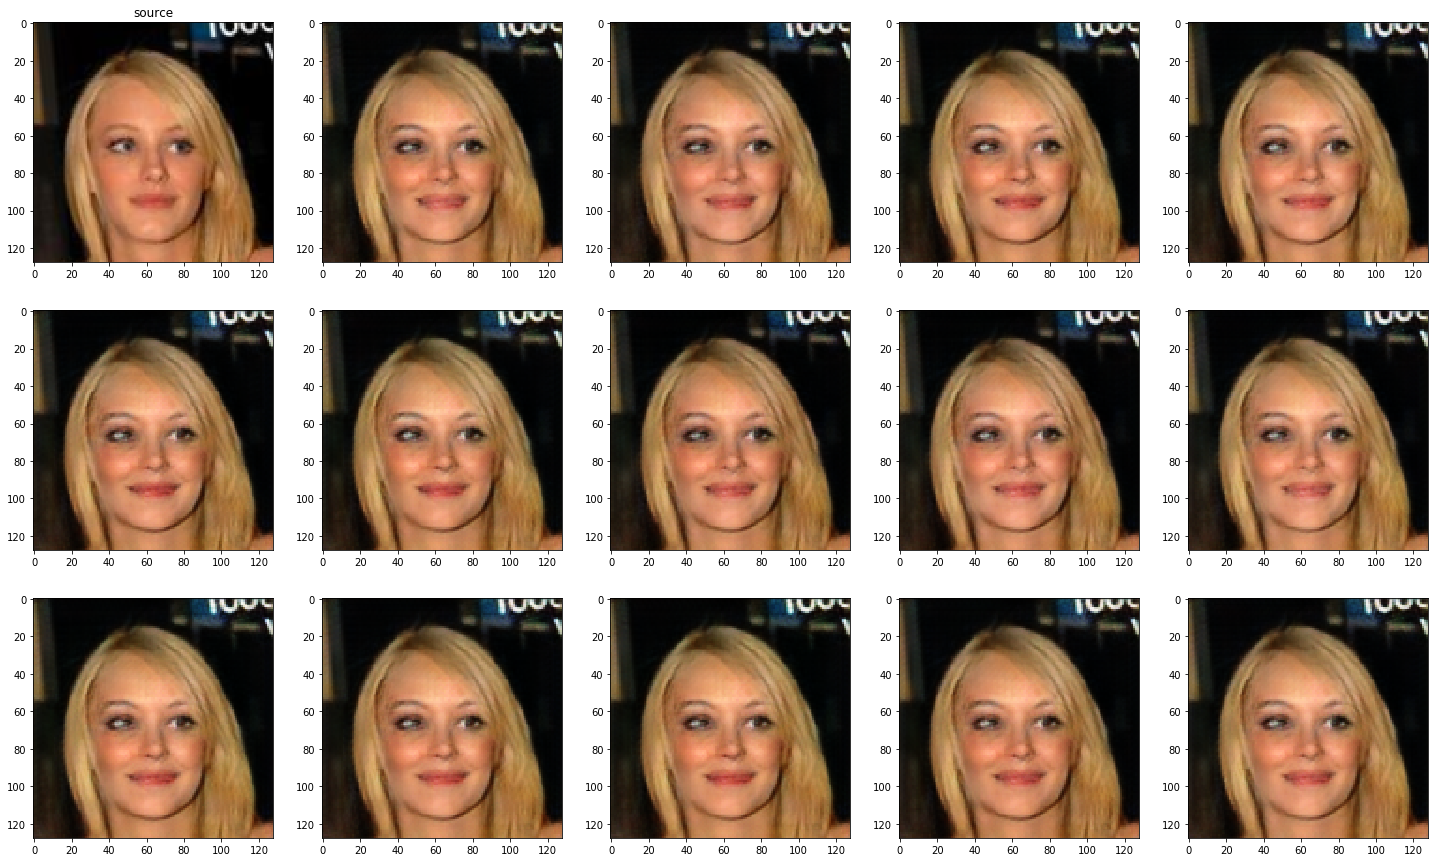

In [28]:
length = 3
width = 5
target_label = 2

images = data["target"][target_label]
np.random.seed(0)
a = np.random.choice(np.arange(num), length*width-1, False)
fig = plt.figure(figsize=(5*width, 5*length))
index = 1
ax = fig.add_subplot(length, width, index)
ax.imshow(data["source"])
ax.set_title("source")

for i in range(length*width-1):
    index = i+2
    ax = fig.add_subplot(length, width, index)
    ax.imshow(images[a[i]])

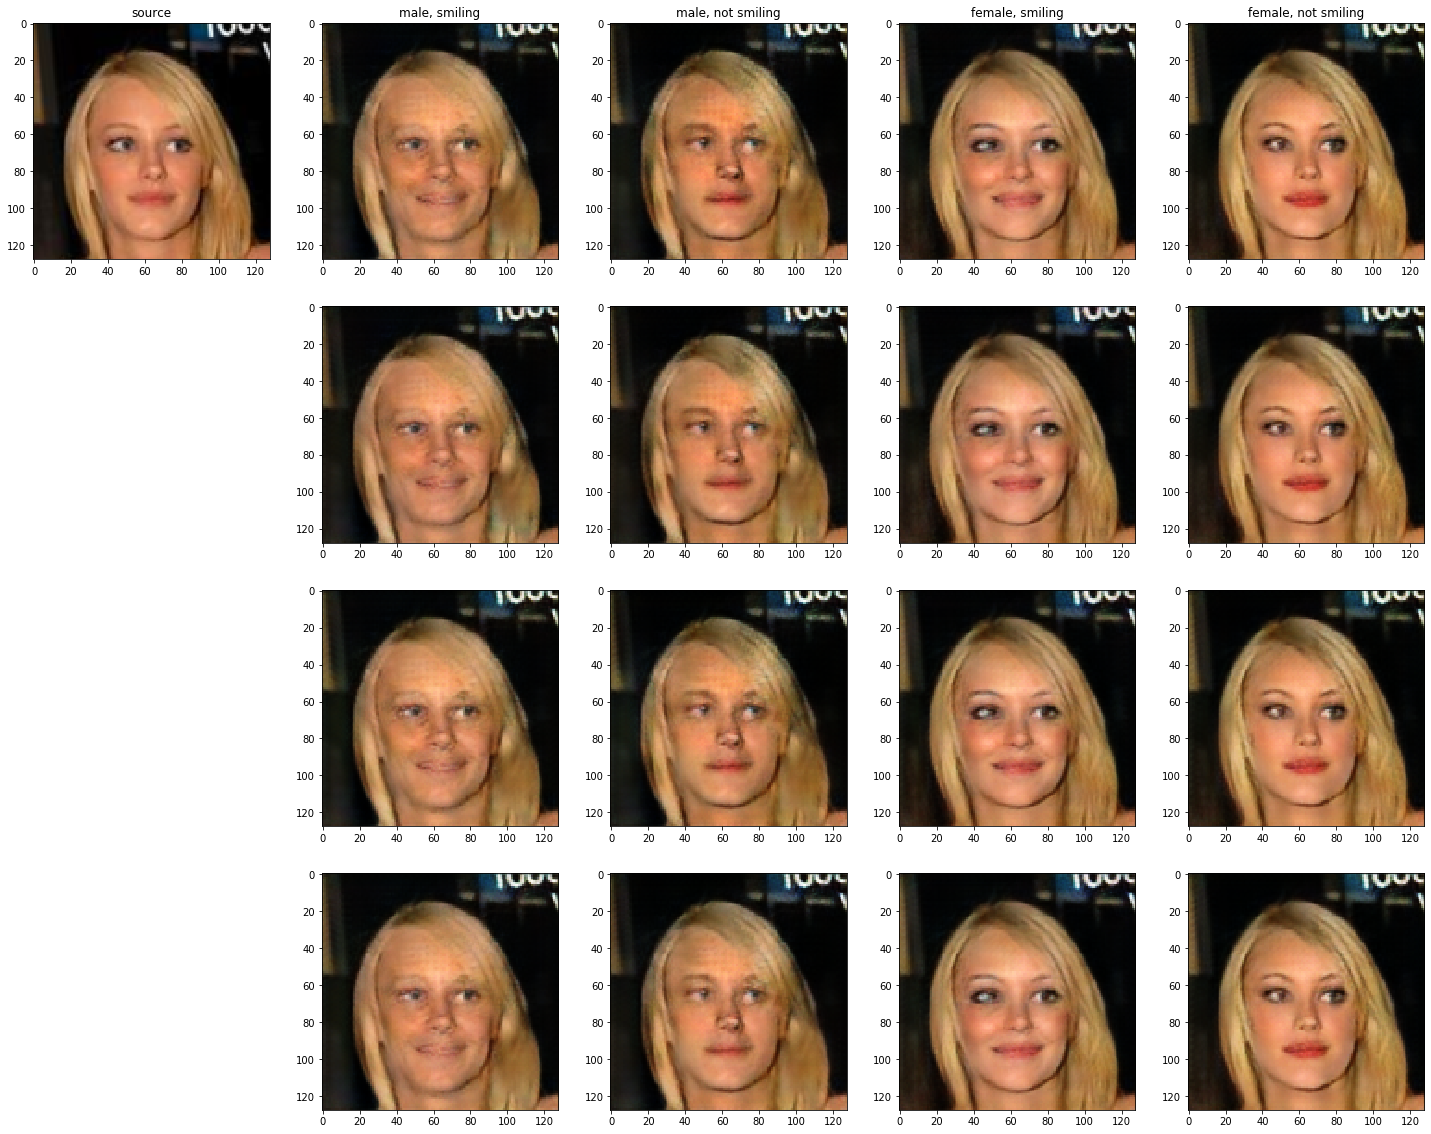

In [29]:
length = 4
images = data["target"]

width = len(classes)+1
fig = plt.figure(figsize=(5*width, 5*length))
np.random.seed(0)
a = np.random.choice(np.arange(num), length, False)
index = 1
ax = fig.add_subplot(length, width, index)
ax.imshow(data["source"])
ax.set_title("source")

for i in range(length):
    for j in classes:
        index = i*(len(classes)+1)+j+2
        ax = fig.add_subplot(length, width, index)
        ax.imshow(images[j][a[i]])
        if i == 0:
            ax.set_title(label_discription[j])

## PRDC

### data

In [30]:
num = 1000
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=0, test_num=num)

In [31]:
dataloader = torch.utils.data.DataLoader(dataset=testset, batch_size=1000, shuffle=False)
for itr, data in enumerate(dataloader):
    data_image = data[0].to(device)
    data_label = data[1].to(device)
    
    if itr==0:
        labels = cuda2cpu(data_label)
        samples = cuda2cpu(data_image)
    else:
        labels = np.concatenate([labels, cuda2cpu(data_label)], axis=0)
        samples = torch.cat([samples, cuda2cpu(data_image)], axis=0)

In [32]:
index = len(testset) - 11

latent = np.random.randn(num, ndim)
data, label = get_samples(netG, netE, testset, index, latent, classes, ref_label, ndim, image_type="tensor", batch=32, device=device, conventional_E=True)

### evaluation

In [33]:
fe_list = ["vgg-initialization", 
           "vgg-ImageNet", 
           "vgg-CelebA"]

In [34]:
ge = GAN_evaluation(fe_list[0], device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

Num real: 1000 Num fake: 1000


{'precision': 1.0, 'recall': 0.0, 'density': 0.4526, 'coverage': 0.005}

In [35]:
ge = GAN_evaluation(fe_list[1], device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /opt/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth
47.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

57.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

85.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_

Num real: 1000 Num fake: 1000


{'precision': 0.999,
 'recall': 0.0,
 'density': 0.5658000000000001,
 'coverage': 0.019}

In [36]:
ge = GAN_evaluation(fe_list[2], device, classes, [target_label])
metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
metrics

Num real: 1000 Num fake: 1000


{'precision': 1.0,
 'recall': 0.009,
 'density': 1.0837999999999999,
 'coverage': 0.03}

In [37]:
def evaluation_init(fe_list, classes, metrics):
    GAN_eval = {}
    for fe in fe_list:
        GAN_eval[fe] = {}
        for source_label in classes:
            GAN_eval[fe][source_label] = {}
            for target_label in classes:
                GAN_eval[fe][source_label][target_label] = {}
                GAN_eval[fe][source_label][target_label] = {}
                for metric in metrics.keys():
                    GAN_eval[fe][source_label][target_label][metric] = []
    return GAN_eval

In [38]:
sample_num = 100
init = True

if init:
    GAN_eval = evaluation_init(fe_list, classes, metrics)
    start = 0
else:
    start = len(GAN_eval[fe_list[0]][0][0]["coverage"])
    
for i in range(sample_num):
    clear_output(wait=True)
    print(i)
    for source_label in classes:
        index = source_label*num + (start+i)
        data, label = get_samples(netG, netE, testset, index, latent, classes, ref_label, ndim, image_type="tensor", batch=32, device=device, conventional_E=True)
        for target_label in classes:
            for fe in fe_list:
                ge = GAN_evaluation(fe, device, classes, [target_label])
                metrics = ge.get_prdc(samples[labels==target_label], data["target"][target_label], preprocess=True)
                for metric in metrics.keys():
                    GAN_eval[fe][source_label][target_label][metric].append(metrics[metric])

99
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num real: 1000 Num fake: 1000
Num rea

In [39]:
save = True
path = f"../data/results/01/01_GAN_evaluation_cycle{lbd['cycle']}_idt{lbd['idt']}.pkl"

if save:
    pickle_save(GAN_eval, path)